#Rozdiel oproti AlphabetDegradation.ipynb
Rozdiel je len v tom, ze tu sa nespracovava cely casovy rad, ale len priblizne jeho druha polovica. Tam som totiz pozoroval narast poctu roznych symbolov, ktore sa pouzivaju za rovnake casovi usek a chcel som vediet, ci je to znak degradacie abecedy symbolov. Porovnavam si teda tieto dve analyzy.

In [2]:
from src import incremental_transformer as it
from src import shift_comparison_predictor as shift_pred
from src import simple_comparison_predictor as simple_pred
import pandas as pd
from src import normalization as norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib.pylab as plt
# plt.rcParams['figure.figsize'] = 12, 9
plt.rcParams['figure.figsize'] = 7, 5

In [4]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

In [5]:
filename = "~/shared/energo_data/belgicko.csv"
data = pd.DataFrame.from_csv(filename, index_col=[0])

In [6]:
sample_data = data[:(96*7*10)]

In [7]:
normalization = norm.ZNormalization()
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(sample_data.value[0:(96*7)])

In [8]:
(len(data)/2)

187248

In [12]:
trans = it.IncrementalTransformer(96, 96, 2.3, normalization=normalization)
#symbols = trans.transform(data.value[(len(data)/2):])
symbols = trans.transform(data.value[200000:])

In [13]:
ids = [symbol.id for symbol in symbols]
counts = pd.Series(ids).value_counts().values

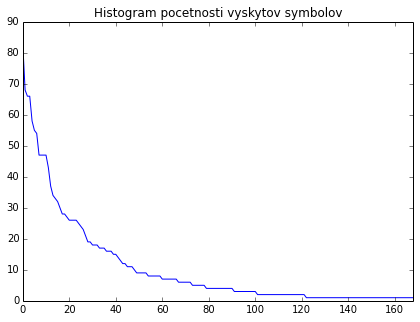

In [14]:
ax = pd.Series(counts).plot(title='Histogram pocetnosti vyskytov symbolov')

In [15]:
len(set(ids))

169

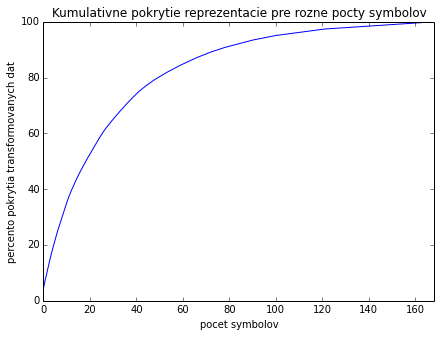

In [16]:
total = len(ids)
ax = (pd.Series(cumsum(counts)) * 100 / total).plot(title='Kumulativne pokrytie reprezentacie pre rozne pocty symbolov')
ax.set_xlabel("pocet symbolov")
ax.set_ylabel("percento pokrytia transformovanych dat")

In [17]:
len([item for item in counts if item <= 2])

68

* rozdelit idcka na nejake 3 skupiny: caste, bezne a jedinecne (jeden alebo dva vyskyty). V histograme ich zvyraznit najeak farebne, napriklad rozdelit na 3 sekcie. Spravit obrazok, kde rozdelim celu historiu na rovnako dlhe useky, a pre kazdy usek ukazem, kolko z ktorych symbolov sa tam po prvy krat objavilo a druhy v ktorom bude kolko z ktorych symbolov sa tam objavilo vobec (nie po prvy krat). Vzniknu mi tak dva obrazky, a v kazdom budu 3 rozne ciary.
Napriklad idcka, ktor pokryvaju prvych 50% dat su caste, tie, ktore sa opakuju len raz su jedinecne a ostatne su bezne. Tu som velmi striktny pri jedinecnych. Mohlo by to byt kludne 2 krat alebo znova nejake percento.
* Podobny obrazok by sa dal spravit aj z toho, kolko prvych vyskytov vobec sa udialo v tom ktorom case. To by sa dalo spravit ako sucet v tom prvom obrazku
* ak sa nejaky symbol opakuje viac ako n krat, ako dlho trva, niez sa zopakuje? To by mohlo naznacit ako dlho si mam pamatat symbol. ktory nedosiahol kriticke mnozstvo


In [18]:
frequent_count = len([item for item in cumsum(counts) if float(item) / total < .5])
frequent_count

19

In [19]:
rare_count = len([item for item in counts if item <= 1])
rare_count

47

In [20]:
unique_count = len(set(ids)) # pocet uinikatnych symbolov
unique_count

169

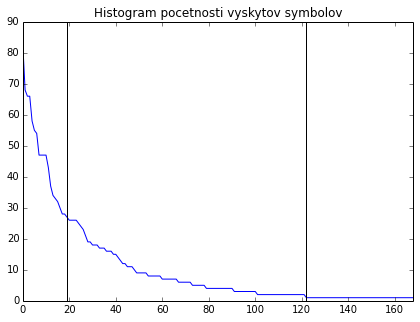

In [21]:
ax = pd.Series(counts).plot(title='Histogram pocetnosti vyskytov symbolov')
plt.axvline(x=frequent_count, color='black')
plt.axvline(x=(unique_count - rare_count), color='black')

In [22]:
frequent_ids = set(pd.Series(ids).value_counts().keys()[:frequent_count])
common_ids = set(pd.Series(ids).value_counts().keys()[frequent_count:(unique_count - rare_count)])
rare_ids = set(pd.Series(ids).value_counts().keys()[(unique_count - rare_count):])
len(frequent_ids) + len(common_ids) + len(rare_ids)

169

In [23]:
def split(a, n):
    k, m = len(a) / n, len(a) % n
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in xrange(n)]

In [35]:
bins = split(ids, 10)

In [36]:
rare_bins = []
frequent_bins = []
common_bins = []
for bucket in bins:
    rare_bins.append(len([i for i in bucket if i in rare_ids]))
    frequent_bins.append(len([i for i in bucket if i in frequent_ids]))
    common_bins.append(len([i for i in bucket if i in common_ids]))
    
# first_occurrences = pd.DataFrame()
all_occurrences = pd.DataFrame()
all_occurrences['Common'] = common_bins
all_occurrences['Rare'] = rare_bins
all_occurrences['Frequent'] = frequent_bins


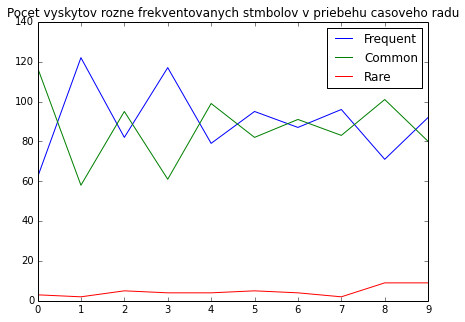

In [37]:
all_occurrences.plot(y=['Frequent', 'Common', 'Rare'], title='Pocet vyskytov rozne frekventovanych stmbolov v priebehu casoveho radu')

# Co mi to povedalo?
pocas celeho priebehu je vyskytov nefrekventovanych symbolov velmi malo. Len malo teda prispievaju k celkovej reprezentacii. Ak by som ich teda vyhodil, tak by to mohlo zlepsit presnost.
Ku koncu sa zriedkavych symbolov objavuje viac. To je preto, ze na konci nestihli byt frekventovane tie, ktore sa objavili len raz.

In [38]:
frequent_set = set(pd.Series(ids).value_counts().keys()[:frequent_count])
common_set = set(pd.Series(ids).value_counts().keys()[frequent_count:(unique_count - rare_count)])
rare_set = set(pd.Series(ids).value_counts().keys()[(unique_count - rare_count):])

rare_bins = []
frequent_bins = []
common_bins = []
for bucket in bins:
    r=0; f=0;c=0
    for i in bucket:
        if i in rare_set:
            r+=1; rare_set.discard(i)
        if i in frequent_set:
            f+=1; frequent_set.discard(i)
        if i in common_set:
            c+=1; common_set.discard(i)
    rare_bins.append(r)
    frequent_bins.append(f)
    common_bins.append(c)
    
first_occurrences = pd.DataFrame()
first_occurrences['Common'] = common_bins
first_occurrences['Rare'] = rare_bins
first_occurrences['Frequent'] = frequent_bins
first_occurrences['All fist occurences'] = first_occurrences['Common'] + first_occurrences['Rare'] + first_occurrences['Frequent']

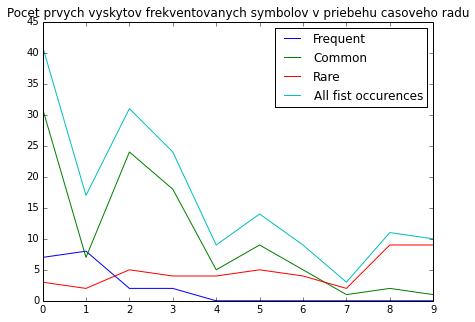

In [39]:
first_occurrences.plot(y=['Frequent', 'Common', 'Rare', 'All fist occurences'], title='Pocet prvych vyskytov frekventovanych symbolov v priebehu casoveho radu')

#Co mi to povedalo?
Najviac frekventovanych symbolov bolo vytvorenych hned na zaciatku. Uz takmer vobec sa nove nepridavali.
Bezne symboly sa objavovali v nejakych navaloch, pravdepodobne pri nejakych zmenach tvaru casoveho radu alebo nejakej vacsej sezonnosti.
Znovu, na konci sa nefrekventovane symboly objavovali viac krat.
Pri pohlade na sumu prvych vyskytov sa zda, ze je celkom dobre rozdelit symboly do 3 alebo viacerych skupin. Udrzovat frekventovane stale, vzacne zahadzovat a bezne mozno po case obmienat. Tam by mohlo celkom zafungovat exponencialne zabudanie.

Toto by bolo dobre otestovat na syntetickom casovom rade, kde presne viem, kedy sa mi meni vzor a kedy zavediem novy tvar.

#todo
ak skutocne plati, ze v tych miestach, kde sa vytvoril kopec je nejaka zmena struktury casoveho radu, tak by s tym mali korelovat aj krivky ziskane z poslednych vyskytov casovych radov.
Zaroven by malo platiti, ze v kazdom bine by mal byt priblyzne rovnaky pocet roznych symbolov pouzitych. To by znamenalo, ze na zapamatanie nejakeho useko s uplnou presnostou mi staci nejake mnozstvo pamate. Zaroven by som potom mohol definovat mieru zabudania a vedel z toho nastavit parametre zahadzovania alebo spajania symbolov.

Na overenie by som potreboval nejaky generator sezonnych casovych radov, ktory by vedel zapojit concept drift a to dokonca na niekolkych urovniach. Na prvej urovni aby som vedel experimentovat s priebeznym vytvaranim novych symbolov a na druhej urovni aby som vedel modelovat globalnu zmenu v strukture casoveho radu. Existuje nejaky stanbdardny model, ktory sa pouziva? Alebo si mam vytvorit nieco sam? 

In [40]:
frequent_set = set(pd.Series(ids).value_counts().keys()[:frequent_count])
common_set = set(pd.Series(ids).value_counts().keys()[frequent_count:(unique_count - rare_count)])
rare_set = set(pd.Series(ids).value_counts().keys()[(unique_count - rare_count):])

rare_bins = []
frequent_bins = []
common_bins = []
for bucket in reversed(bins):
    r=0; f=0;c=0
    for i in bucket:
        if i in rare_set:
            r+=1; rare_set.discard(i)
        if i in frequent_set:
            f+=1; frequent_set.discard(i)
        if i in common_set:
            c+=1; common_set.discard(i)
    rare_bins.append(r)
    frequent_bins.append(f)
    common_bins.append(c)
    
common_bins.reverse()
rare_bins.reverse()
frequent_bins.reverse()

last_occurrences = pd.DataFrame()
last_occurrences['Common'] = common_bins
last_occurrences['Rare'] = rare_bins
last_occurrences['Frequent'] = frequent_bins
last_occurrences['All last occurences'] = last_occurrences['Common'] + last_occurrences['Rare'] + last_occurrences['Frequent']

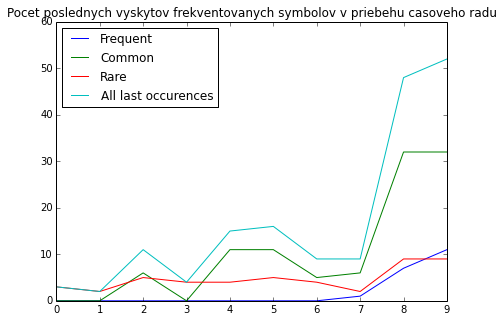

In [41]:
last_occurrences.plot(y=['Frequent', 'Common', 'Rare', 'All last occurences'], title='Pocet poslednych vyskytov frekventovanych symbolov v priebehu casoveho radu')

#Co mi to povedalo
toto je zvlastne. Vobec to nekoreluje s poctom novych symbolov. Predpokladal som, ze ak vela symbolov v nejakom tyzdni pouzilo velmi vela po prvy krat, tak tam zaroven bude vela symbolov, ktore sa pouziju posledny krat. Teda ze sa ten prud niekam posunul a zmenila sa abeceda symbolov, ktore sa maju pouzivat. Tak to ale zda sa nieje. Teda nelati, ze ak vznikne vela novych symbolov, tak tie predchadzajuce sa uz nebudu pouzivat. 

In [57]:
rare_bins = []
frequent_bins = []
common_bins = []
for bucket in bins:
    rare_bins.append(len(unique([i for i in bucket if i in rare_ids])))
    frequent_bins.append(len(unique([i for i in bucket if i in frequent_ids])))
    common_bins.append(len(unique([i for i in bucket if i in common_ids])))

unique_occurrences = pd.DataFrame()
unique_occurrences['Common symbols'] = common_bins
unique_occurrences['Rare symbols'] = rare_bins
unique_occurrences['Frequent symbols'] = frequent_bins
unique_occurrences['All unique symbols'] = unique_occurrences['Common symbols'] + unique_occurrences['Rare symbols'] + unique_occurrences['Frequent symbols']

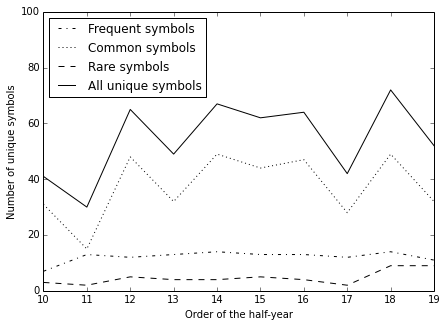

In [59]:
ax = unique_occurrences.plot(y=['Frequent symbols', 'Common symbols', 'Rare symbols', 'All unique symbols'], 
#                         title='Pocet roznych symbolov v okne v priebehu casoveho radu')
                        style=['-.',':','--','-'], color=['black','black','black','black'])
plt.ylim(ymax = 100)
# plt.xlim(xmin = 10, xmax=20)
ax.set_xticklabels(xrange(10,20))
ax.set_ylabel('Number of unique symbols')
ax.set_xlabel('Order of the half-year')

#Co mi to povedalo
Zo zaciatku je pocet roznych symbolov v okne viac menej rovnaky. Kolise to stale okolo toho isteho cisla. Za polovicou sa to ale nejak meni. Frekventovane sa postupne pouzivaju menej a menej. Vzacne stale viac a viac, ale obe tieto veci sa dali cakat. Vzacne sa este nestihli stat beznymi a pri frekventovanych sa prud niekam posuva a bezne symboly sa este nestihl istat frekventovanymi.

Zvlastne su ale tie bezne. Je ich velmi vela. Ku koncu ich je dvojnasobok ako na zaciatku a aj celkovy pocet roznych symbolov sa zdvojnasobil. Je mozne ze je to len vlastnost tych, dat, ktore som spracovaval, ale mozno to indikuje nejaku vlastnost degradacie abecedy symbolov. 

Chcelo by sa pozriet na to, kolko bude takychto symbolov ak by som transformoval len druhu polovicu datasetu. Ak by bol ten pocet podobny, tak by to znamenalo, ze ta abeceda celkom dobre pokryva aj tie neskorsie data. Ak by ale pri transformacii len druhej polovice abecedy vznikalo vyrazne menej symbolov (priebezne by bolo menej unikatnych symbolov), tak by to znamenalo, ze neskor tie symboly uz nereprezentuju dobre data a ze vela novych dat spada na hranicu symbolov a teda sa lahko stane, ze mala zmena v datach uz spada do ineho symbolu. Toto by sa nemalo stavat. dalo by sa to riesit napriklad tak, ze by sa symboly rozdelovali a nesledovala by sa len frekvencia ich vyskytu, ale aj ich vek. Vek by bol pri zabudani implicitne riesny nejakym zabudacim koeficientom, ale pri tejto analyze by som si mal vykreslit aj podobne obrazky, kde nebudem zobrazovat len frekvenciu symbolu, ale aj ich vek alebo zivotnost (rozdiel medzi prvym a poslednym vyskytom).
Mozno by sa na vizualizaciu dal pouzit nejaky scatterplot, kde by boli triedy symbolov podla poctu vyskytov naznacene farbou a ich vek by bol naznaceny sytostou farby.

Takze potrebujem sa na tuto analyzu pozriet dvojako:
* transformovat len druhu polovicu data a porovnat pocet symbolov pri transformacii celych dat
* pozriet sa aj na vek symbolov, nie len na ich frekvenciu.

##frekvencia
dva rozne napady na vizualizaciu:
1. 1d scatterplot, kde farba znamena frekvenciu a sytost vek
2. 2d scatterplot, kde na jednej osy bude frekvencia a na druhej rozdiel medzi prvym a poslednym vyskytom pre symbol. Mozno sa tam najdu nejaky outliery. Aky tvar bude mat tento scatter? Budu tam nejake skupiny? Bude to len nejaky pas? Budu tam nejaky outlyery?

#Sumar rozdielu oproti analyze celeho casoveho radu, nielen druhej polovice
celkovy pocet unikatnych symbolov sa znizil z 316 na 241
takmer vsetko zostalo rovnake ako pri predchadzajuecej analyze, len tam uz niesu vidiet ziadne velke posuny casoveho radu. Nove symboly vznikaju a stare zanikaju podla nejakeh ostabilneho trendu.
Velky rozdiel je ale v priebeznom pocte unikatnych symbolov pouzitych za nejaky casovy usek. ten je tu stabilny a podstatne nizsi ako to bolo v druhej polovici casoveho radu pri analyze celych dat.
To naznacuje, ze ta abeceda skutocne degraduje a bolo by treba nejak menit abecedu symbolov.

Zaujimave je, ze ked som tuto abecedu opakoval pre druhu polovicu dat, ale zachytil som tam aj data pref tym posunim, tak sa takmer nezmenil pocet unikatnych symbolov. Pomerne vyrazne ale klesol priemerny pocet unikatnych symbolov pouzitych v nejakom okne aj ked ten tvar (rast ku koncu) tam zostal. Takze sa mi pomerne dobre podarilo lokalizovat tu vyraznu zmenu, ktora posunula cely casovy rad.